# PSYC471 Final Project – Course Stay/Drop DDM
## Overview
This computational modeling project explores how college students' social connectivity may influence their decision-making with course stay/drop for a single course using Drift Diffusion Models (DDM). Specifically, we are examining the relationship between connectedness of college students and decision-making time to stay or drop in a single course. The hypothesis is that students with higher connectedness would be able to make decisions faster than those with lower connectedness. Two hypotheses are formulated:

### Hypothesis 1:
Greater connectedness leads to more frequent social events providing information about the course (“information events”), which results in quicker decision making.

### Hypothesis 2:
Greater connectedness leads to lowered caution making decisions due to external factors, such as peer pressure, which results in quicker decision making.
### Model 1: Null DDM without Information Events
Drift-diffusion model will be the control condition and simulate decision-making with random drift rates. Threshold decays exponentially to simulate pressure from the decision deadline. 

### Model 2: Drift-Changing DDM
Drift-diffusion model will simulate decision-making based on social connectedness and information events affecting drift rates. Threshold decays exponentially to simulate pressure from the decision deadline.

### Model 3: Threshold-Changing DDM
Drift-diffusion model will simulate decision-making based on social connectedness and information events increasing threshold collapsing rates.

## Code
### Import Necessary Libraries

In [24]:
import numpy as np
import matplotlib.pyplot as plt
import statistics
import pandas as pd
from scipy.optimize import minimize

### Global Simulation Parameters

The following parameters will be used globally throughout our simulations. These include the total time, time step, bias towards staying in the course, base drift rate, noise level, initial decision threshold, and the number of trials.

In [25]:
T = 21  # Total time in days
dt = 1/24  # Time step in a day (hours)
bias = 0.25  # Bias towards "Stay" 
mu = 0.2  # Base drift rate
sigma = 0.1  # Noise level
threshold = 1.0  # Initial decision threshold
trials = 1000  # Number of trials

### Model 1: Null DDM without Information Events

In [26]:
# Function to simulate the Null Drift Diffusion Model in which social connectedness does not affect the results
def simulate_ddm_null(T, dt, bias, mu, sigma, event_probability, threshold):
    time_steps = int(T / dt)
    X = np.zeros(time_steps)
    decision_time = None
    X[0] = np.random.normal(0, 0.20) + bias

    for t in range(1, time_steps):      
        drift = mu
        noise = sigma * np.sqrt(dt) * np.random.normal()
        X[t] = X[t-1] + drift * dt + noise
        threshold *= np.exp(-0.0001 * t * dt)

        if abs(X[t]) >= threshold:
            decision_time = t * dt
            break

    if decision_time is None:
        decision_time = T

    return X, decision_time

### Model 2: Drift-Changing DDM

In [27]:
# Function to simulate the Drift-Changing Drift Diffusion Model
def simulate_ddm_drift_change(T, dt, bias, mu, sigma, event_probability, threshold):
    time_steps = int(T / dt)
    X = np.zeros(time_steps)
    decision_time = None
    X[0] = np.random.normal(0, 0.20) + bias

    for t in range(1, time_steps):
        if np.random.rand() < event_probability: # information event occurs
            if np.random.rand() < 0.80: # 80% of information events will support "Stay"
                mu += np.random.normal(0, 0.1)
            else: # 20% of information events will support "Drop"
                mu -= np.random.normal(0, 0.1)

        drift = mu
        noise = sigma * np.sqrt(dt) * np.random.normal()
        X[t] = X[t-1] + drift * dt + noise
        threshold *= np.exp(-0.0001 * t * dt)

        if abs(X[t]) >= threshold:
            decision_time = t * dt
            break

    if decision_time is None:
        decision_time = T

    return X, decision_time

### Model 3: Threshold-Changing DDM

In [28]:

# Function to simulate the Threshold-Changing Drift Diffusion Model
def simulate_ddm_threshold_change(T, dt, bias, mu, sigma, event_probability, threshold):
    time_steps = int(T / dt)
    X = np.zeros(time_steps)
    decision_time = None
    X[0] = np.random.normal(0, 0.20) + bias

    for t in range(1, time_steps):
        if np.random.rand() < event_probability: # information event occurs
            if np.random.rand() < 0.80: # 80% of information events will apply pressure
                threshold -= np.random.rand()/50  # Change in threshold
            else: # 20% of information events will reduce pressure
                threshold += np.random.rand()/50  # Change in threshold
        
        drift = mu
        noise = sigma * np.sqrt(dt) * np.random.normal()
        X[t] = X[t-1] + drift * dt + noise
        threshold *= np.exp(-0.0002 * t * dt)

        if abs(X[t]) >= threshold:
            decision_time = t * dt
            break

    if decision_time is None:
        decision_time = T

    return X, decision_time



### Data Analysis and Visualization
Now we have defined each of the models, we analyze the results from our simulations and visualize the decision-making processes for each model.

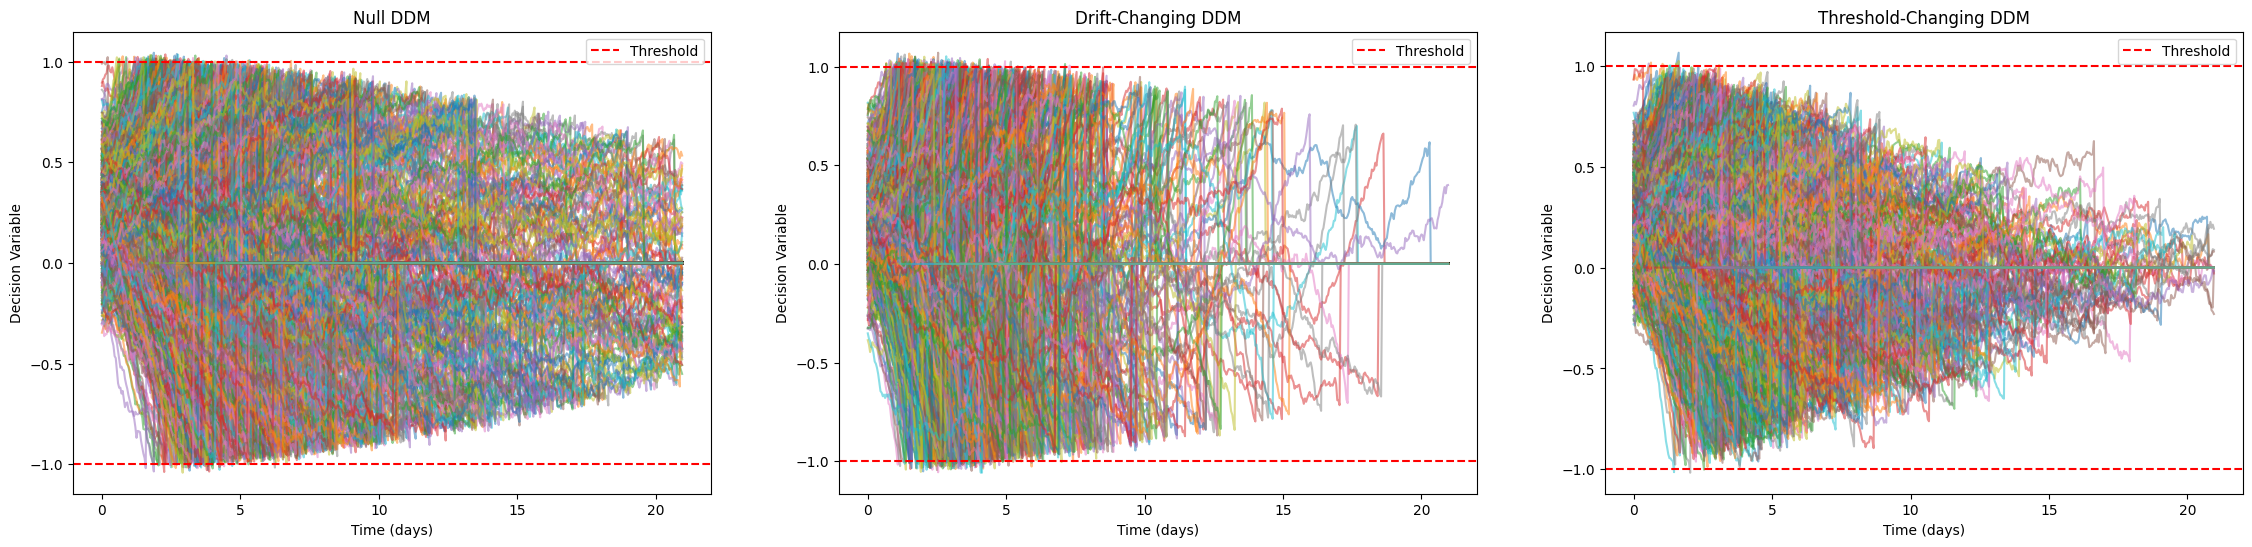

In [29]:
# Function for analyzing and plotting DDM simulation results
def analyze_and_plot_ddm(simulate_ddm_func, title, ax):
    decision_times = []
    for i in range(trials):
        probability = np.random.normal(0.25, 0.05)
        mu = np.random.normal(0, 0.2)
        X, decision_time = simulate_ddm_func(T, dt, bias, mu, sigma, probability, threshold)
        decision_times.append(decision_time)
        ax.plot(np.arange(0, T, dt)[:len(X)], X, alpha=0.5)

    avg_decision_time = np.mean(decision_times)
    med_decision_time = statistics.median(decision_times)
    percentage_over_7_days_below_14_days = len([t for t in decision_times if 7 < t <= 14]) / trials * 100
    percentage_over_14_days = len([t for t in decision_times if t > 14]) / trials * 100

    ax.set_title(title)
    ax.set_xlabel('Time (days)')
    ax.set_ylabel('Decision Variable')
    ax.axhline(y=threshold, color='r', linestyle='--', label='Threshold')
    ax.axhline(y=-threshold, color='r', linestyle='--')
    ax.legend()

    return avg_decision_time, med_decision_time, percentage_over_7_days_below_14_days, percentage_over_14_days


# Initialize plots for side-by-side comparison
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(28, 6))

# Run, analyze, and plot Null Drift Diffusion Model
null_stats = analyze_and_plot_ddm(simulate_ddm_null, 'Null DDM', ax1)

# Run, analyze, and plot Drift-Changing Drift Diffusion Model
drift_change_stats = analyze_and_plot_ddm(simulate_ddm_drift_change, 'Drift-Changing DDM', ax2)

# Run, analyze, and plot Threshold-Changing Drift Diffusion Model
threshold_change_stats = analyze_and_plot_ddm(simulate_ddm_threshold_change, 'Threshold-Changing DDM', ax3)

# Show the figure
plt.show()



### Parameter Estimation and Recovery
We perform parameter recovery for each model to assess the accuracy of our simulations in representing the decision-making process.

In [30]:
# Function to generate synthetic data for parameter estimation
def generate_synthetic_data(simulate_ddm_func, T, dt, bias, mu, sigma, event_probability, threshold, trials):
    decision_times = []
    for _ in range(trials):
        _, decision_time = simulate_ddm_func(T, dt, bias, mu, sigma, event_probability, threshold)
        decision_times.append(decision_time)
    return decision_times

# Function for parameter estimation and optimization
def estimate_parameters(simulate_ddm_func, synthetic_data, T, dt, trials):
    def objective_function(params):
        bias, mu, sigma, event_probability, threshold = params
        estimated_data = generate_synthetic_data(simulate_ddm_func, T, dt, bias, mu, sigma, event_probability, threshold, trials)
        return sum((np.array(estimated_data) - np.array(synthetic_data)) ** 2)

    initial_guess = [0.25, 0.2, 0.1, 0.25, 1.0]
    result = minimize(objective_function, initial_guess, method='Nelder-Mead') # Nelder-Mead minimization algorithm was used since DDM assumes a noisy decision-making process
    return result.x

# Function for parameter recovery process
def parameter_recovery_process(simulate_ddm_func, T, dt, original_parameters, trials):
    synthetic_data = generate_synthetic_data(simulate_ddm_func, T, dt, *original_parameters, trials)
    estimated_parameters = estimate_parameters(simulate_ddm_func, synthetic_data, T, dt, trials)
    return original_parameters, estimated_parameters

# Perform parameter recovery for Null DDM
original_params_null, recovered_params_null = parameter_recovery_process(simulate_ddm_null, T, dt, [0.25, 0.2, 0.1, 0.25, 1.0], trials)
print("Original Parameters (Null DDM):", original_params_null)
print("Recovered Parameters (Null DDM):", recovered_params_null)
print("Absolute Difference in Percentage:"), (recovered_params_null-original_params_null)/original_params_null*100, "%"

# Perform parameter recovery for Drift-Changing DDM
original_params_drift, recovered_params_drift = parameter_recovery_process(simulate_ddm_drift_change, T, dt, [0.25, 0.2, 0.1, 0.25, 1.0], trials)
print("Original Parameters (Drift-Changing DDM):", original_params_drift)
print("Recovered Parameters (Drift-Changing DDM):", recovered_params_drift)
print("Absolute Difference in Percentage:"), (recovered_params_drift-original_params_drift)/original_params_drift*100, "%"

# Perform parameter recovery for Threshold-Changing DDM
original_params_threshold, recovered_params_threshold = parameter_recovery_process(simulate_ddm_threshold_change, T, dt, [0.25, 0.2, 0.1, 0.25, 1.0], trials)
print("Original Parameters (Threshold-Changing DDM):", original_params_threshold)
print("Recovered Parameters (Threshold-Changing DDM):", recovered_params_threshold)
print("Absolute Difference in Percentage:"), (recovered_params_threshold-original_params_threshold)/original_params_threshold*100, "%"

'# Function to generate synthetic data for parameter estimation\ndef generate_synthetic_data(simulate_ddm_func, T, dt, bias, mu, sigma, event_probability, threshold, trials):\n    decision_times = []\n    for _ in range(trials):\n        _, decision_time = simulate_ddm_func(T, dt, bias, mu, sigma, event_probability, threshold)\n        decision_times.append(decision_time)\n    return decision_times\n\n# Function for parameter estimation and optimization\ndef estimate_parameters(simulate_ddm_func, synthetic_data, T, dt, trials):\n    def objective_function(params):\n        bias, mu, sigma, event_probability, threshold = params\n        estimated_data = generate_synthetic_data(simulate_ddm_func, T, dt, bias, mu, sigma, event_probability, threshold, trials)\n        return sum((np.array(estimated_data) - np.array(synthetic_data)) ** 2)\n\n    initial_guess = [0.25, 0.2, 0.1, 0.25, 1.0]\n    result = minimize(objective_function, initial_guess, method=\'Nelder-Mead\') # Nelder-Mead algorit

### Results Comparison
Finally, we compile and compare the results from each model to understand how different levels of social connectivity impact decision-making.

In [31]:
# Create a DataFrame for comparison
df = pd.DataFrame({
    'Metric': ['Mean Decision Time (days)', 'Median Decision Time (days)', 'Percentage >7 & <=14 days (%)', 'Percentage >14 days (%)'],
    'Null DDM': null_stats,
    'Drift-Changing DDM': drift_change_stats,
    'Threshold-Changing DDM': threshold_change_stats
})

# Display the DataFrame
print(df)

                          Metric   Null DDM  Drift-Changing DDM  \
0      Mean Decision Time (days)   8.418417            4.906542   
1    Median Decision Time (days)   6.375000            3.979167   
2  Percentage >7 & <=14 days (%)  27.000000           18.400000   
3        Percentage >14 days (%)  18.700000            2.300000   

   Threshold-Changing DDM  
0                6.538083  
1                5.250000  
2               27.500000  
3                7.500000  


## Conclusion

This project explored the relationship between social connectivity and decision-making in college course enrollment. Through computational modeling, we've gained insights into how social factors might influence students' decisions in course stay/drop. However, this project is inconclusive. The model parameters need to be fitted with real data to have the simulations be meaningful.